# Lecture 3 Sector-coupling

## PV, CHP, Bio, Natural-gas, District heating

### 1)Import Packages

In [49]:
import pypsa
import pandapower as pp
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import cartopy.crs as ccrs got an error for this line
import warnings
import subprocess
from shapely.errors import ShapelyDeprecationWarning
import logging

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("pypsa.pf").setLevel(logging.WARNING)
plt.rc("figure", figsize=(10, 8))

### 2)Create a network and set Snapshots

In [50]:
# Create a new PyPSA network
network = pypsa.Network()
network.set_snapshots(range(1))  # Solve for a year 365*24
solver='highs'

### 3)Add Buses

In [51]:
bus= pd.read_csv('buses.csv',header=0)
network.madd(
    "Bus",
    names= bus.bus,
    v_nom=list(bus.v_nom),
    carrier=list(bus.carrier),
    #x=list(bus.x),
    #y=list(bus.y),
)
network.buses

C:\Users\suhas\AppData\Local\Temp\ipykernel_11712\2885349877.py:2: DeprecatedWarning:

madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.



,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
ele_bus,20.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,
heat_bus,1.0,,0.0,0.0,heat,,1.0,0.0,inf,PQ,,
H2_bus,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
gas_bus,1.0,,0.0,0.0,gas,,1.0,0.0,inf,PQ,,
biomass_bus,1.0,,0.0,0.0,biomass,,1.0,0.0,inf,PQ,,


### 4)Add generators

In [52]:
# Read excel file which contains Non renewable generators data
generators=pd.read_csv('generators.csv',header=0)
network.madd(
    "Generator",
    names= generators.generator,
    bus=list(generators.bus),
    carrier=list(generators.carrier),
    p_nom=list(generators.p_nom),
    p_nom_extendable=list(generators.p_nom_extendable),
    marginal_cost=list(generators.marginal_cost),
    efficiency=list(generators.efficiency)
) 
network.generators

C:\Users\suhas\AppData\Local\Temp\ipykernel_11712\273600717.py:3: DeprecatedWarning:

madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.



,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,e_sum_min,e_sum_max,q_set,sign,carrier,marginal_cost,marginal_cost_quadratic,active,build_year,lifetime,capital_cost,efficiency,committable,start_up_cost,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
coal,ele_bus,PQ,,50.0,0.0,False,0.0,inf,0.0,1.0,0.0,-inf,inf,0.0,1.0,coal,50.0,0.0,True,0,inf,0.0,0.35,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
biomass,ele_bus,PQ,,30.0,0.0,True,0.0,inf,0.0,1.0,0.0,-inf,inf,0.0,1.0,biomass,100.0,0.0,True,0,inf,0.0,0.30,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
wind,ele_bus,PQ,,20.0,0.0,True,0.0,inf,0.0,1.0,0.0,-inf,inf,0.0,1.0,wind,0.0,0.0,True,0,inf,0.0,0.30,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


### 5)Add load

In [53]:
# Read excel file which contains Non renewable generators data
load=pd.read_csv('loads.csv',header=0)
network.madd(
    "Load",
    names= load.bus,
    bus=list(load.bus),
    p_set=list(load.p_set),
)
network.loads

C:\Users\suhas\AppData\Local\Temp\ipykernel_11712\2369450305.py:3: DeprecatedWarning:

madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.



,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
ele_bus,ele_bus,,,120.0,0.0,-1.0,True
heat_bus,heat_bus,,,100.0,0.0,-1.0,True
H2_bus,H2_bus,,,20.0,0.0,-1.0,True


### 6)Add links

In [54]:
links = pd.read_csv('links.csv', header=0)
network.madd(
    "Link",
    names=links.name,
    bus0=list(links.bus0),
    bus1=list(links.bus1),
    bus2=list(links.bus2),
    p_nom=list(links.p_nom),
    p_nom_extendable=list(links.p_nom_extendable),
    efficiency=list(links.efficiency),
    efficiency2=list(links.efficiency2),
    capital_cost=list(links.capital_cost),
)
network.links

C:\Users\suhas\AppData\Local\Temp\ipykernel_11712\1213812434.py:2: DeprecatedWarning:

madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.



,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,marginal_cost_quadratic,stand_by_cost,length,terrain_factor,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
heat_pump,ele_bus,heat_bus,,,3.0,True,0,inf,10.0,0.0,True,0.0,inf,0.0,0.0,1.0,900.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0,,0.0
electrolyzer,ele_bus,H2_bus,,,0.8,True,0,inf,10.0,0.0,True,0.0,inf,0.0,0.0,1.0,150.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0,,0.0
gas_boiler,gas_bus,heat_bus,,,0.9,True,0,inf,10.0,0.0,True,0.0,inf,0.0,0.0,1.0,300.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0,,0.0
CHP,gas_bus,ele_bus,,,0.3,True,0,inf,10.0,0.0,True,0.0,inf,0.0,0.0,1.0,1400.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0,heat_bus,0.3
OCGT,gas_bus,ele_bus,,,0.4,True,0,inf,10.0,0.0,True,0.0,inf,0.0,0.0,1.0,600.0,0.0,0.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0,,0.0


### 7)Add carriers

In [55]:
carriers = pd.read_csv('carrier.csv', header=0)
network.madd(
    "Carrier",
    names=carriers.carrier,
    co2_emissions=list(carriers.co2_emissions),
    nice_name=list(carriers.carrier),
)

C:\Users\suhas\AppData\Local\Temp\ipykernel_11712\958285943.py:2: DeprecatedWarning:

madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.



Index(['gas', 'coal', 'wind', 'biomass'], dtype='object', name='carrier')

### 8)Storages

In [56]:
stores = pd.read_csv('stores.csv', header=0)
network.madd(
    "Store",
    names=stores.name,
    e_initial=list(stores.e_initial),
    e_nom=list(stores.e_nom),
    marginal_cost=list(stores.marginal_cost),
    bus=list(stores.bus),
    e_cyclic=list(stores.e_cyclic),
    e_nom_extendable=list(stores.e_nom_extendable),
)
network.stores

C:\Users\suhas\AppData\Local\Temp\ipykernel_11712\3924419094.py:2: DeprecatedWarning:

madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.



,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,e_initial_per_period,e_cyclic,e_cyclic_per_period,p_set,q_set,sign,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,,,,,,
water tank,heat_bus,,,1000000.0,0.0,True,0.0,inf,0.0,1.0,1000000.0,False,True,True,0.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,True,0,inf,0.0
gas_store,gas_bus,,,1000000.0,0.0,True,0.0,inf,0.0,1.0,1000000.0,False,True,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,0.0
hydrogen_store,H2_bus,,,1000.0,0.0,True,0.0,inf,0.0,1.0,1000.0,False,True,True,0.0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,True,0,inf,0.0


storage_units = pd.read_csv('storage_units.csv', header=0)
network.madd(
    "Storage_units",
    names=stores.name,
    e_initial=list(stores.e_initial),
    e_nom=list(stores.e_nom),
    marginal_cost=list(stores.marginal_cost),
    bus=list(stores.bus),
    e_cyclic=list(stores.e_cyclic),
    e_nom_extendable=list(stores.e_nom_extendable),
)
network.stores

### 9)Global constraints

In [57]:
network.add("GlobalConstraint", "co2_limit", sense="<=", constant=2000.0)

Index(['co2_limit'], dtype='object')

In [58]:
network.optimize()

Index(['ele_bus', 'heat_bus', 'H2_bus'], dtype='object', name='Bus')
Index(['heat_pump', 'electrolyzer'], dtype='object', name='Link')
Index(['water tank', 'hydrogen_store'], dtype='object', name='Store')
{'biomass_bus'}
Index(['ele_bus', 'heat_bus', 'H2_bus'], dtype='object', name='Bus')
Index(['heat_pump', 'electrolyzer'], dtype='object', name='Link')
Index(['water tank', 'hydrogen_store'], dtype='object', name='Store')
{'biomass_bus'}
c:\Users\suhas\anaconda3\Lib\site-packages\linopy\common.py:147: UserWarning:

coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.17s
INFO:linopy.solvers:Log file at C:\Users\suhas\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition

('ok', 'optimal')

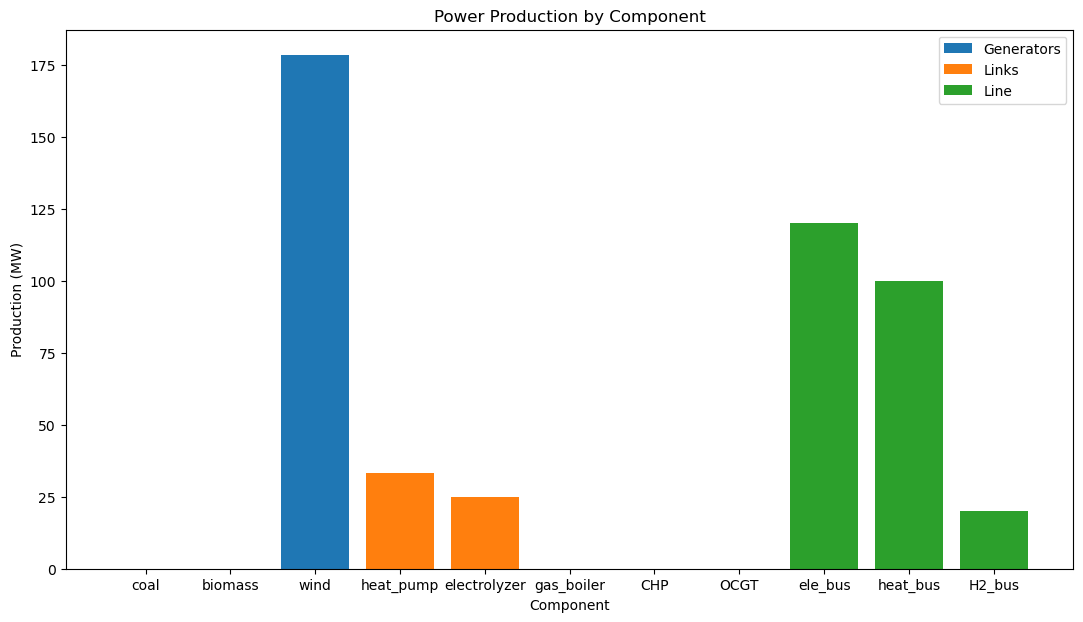

In [59]:
# Your DataFrame df
df = pd.concat([network.generators_t.p.loc[0],
        network.links_t.p0.loc[0],
        network.loads_t.p.loc[0],
    ],
    keys=["Generators", "Links", "Line"],
    names=["Component", "index"],
).reset_index(name="Production")

# Plotting using PyPSA
fig, ax = plt.subplots(figsize=(13, 7))

# Plot generators
df_generators = df[df["Component"] == "Generators"]
ax.bar(df_generators["index"], df_generators["Production"], label="Generators")

# Plot links
df_links = df[df["Component"] == "Links"]
ax.bar(df_links["index"], df_links["Production"], label="Links")

# Plot loads
df_loads = df[df["Component"] == "Line"]
ax.bar(df_loads["index"], df_loads["Production"], label="Line")

# Customize the plot
ax.set_xlabel("Component")
ax.set_ylabel("Production (MW)")
ax.set_title("Power Production by Component")
ax.legend()

# Show the plot
plt.show()
